In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd

# Path to shared folder
shared_folder_path = '/content/drive/My Drive/IDMP'

# List CSV files in the folder
csv_files = [f for f in os.listdir(shared_folder_path) if f.endswith('.csv')]

# Load each CSV file
dataframes = {}
for file in csv_files:
    df_name = file.split('.')[0]
    dataframes[df_name] = pd.read_csv(os.path.join(shared_folder_path, file), low_memory=False)


Dynamically loads all CSV files from a folder into a dictionary of Pandas DataFrames, using the filenames (without .csv) as the keys.

In [4]:
pd.set_option('display.max_columns', None)

In [3]:
# Print DataFrame names, column names, and data types
for df_name, df in dataframes.items():
    print("\nData Preview:")
    print(f"\nDataFrame Name: {df_name}")
    print("Columns and Data Types:")
    print(df.dtypes)


Data Preview:

DataFrame Name: branded_food
Columns and Data Types:
fdc_id                     int64
brand_owner               object
brand_name                object
gtin_upc                  object
ingredients               object
serving_size             float64
serving_size_unit         object
branded_food_category     object
data_source               object
modified_date             object
available_date            object
market_country            object
dtype: object

Data Preview:

DataFrame Name: food_attribute_type
Columns and Data Types:
id              int64
name           object
description    object
dtype: object

Data Preview:

DataFrame Name: food_attribute
Columns and Data Types:
id         int64
fdc_id     int64
name      object
value      int64
dtype: object

Data Preview:

DataFrame Name: food_update_log_entry
Columns and Data Types:
id               int64
description     object
last_updated    object
dtype: object

Data Preview:

DataFrame Name: measure_unit
Column

## Data Preparation for Predicting branded_food_category using machine learning

In [5]:
import pandas as pd

# Assuming dataframes dictionary contains the loaded data

# Step 1: Start with the 'food' table as the primary table
food_df = dataframes['food']

# Step 2: Join 'branded_food' for additional food category and branding details
# Left join on 'fdc_id', which is the common identifier
food_branded_df = food_df.merge(dataframes['branded_food'], on='fdc_id', how='left')

# Step 3: Join 'food_nutrient' to bring in nutrient data
# Left join on 'fdc_id' to keep all records from 'food'
food_nutrient_df = food_branded_df.merge(dataframes['food_nutrient'], on='fdc_id', how='left')


# Step 4: Join 'nutrient' to bring in nutrient names and unit details
# Only select relevant columns from 'nutrient' to avoid duplicate 'id' columns
nutrient_df = dataframes['nutrient'].rename(columns={'id': 'nutrient_id'})  # Rename 'id' to avoid conflicts
food_nutrient_details_df = food_nutrient_df.merge(nutrient_df, left_on='nutrient_id', right_on='nutrient_id', how='left')


# Step 5: Join 'microbe' to bring in microbe data related to the food item
# Only select relevant columns from 'microbe' and rename 'id' to avoid conflicts
microbe_df = dataframes['microbe'].rename(columns={'id': 'microbe_id'})  # Rename 'id' to avoid conflicts
food_microbe_df = food_nutrient_details_df.merge(microbe_df, left_on='fdc_id', right_on='foodId', how='left')


# Step 6: Join 'food_attribute' to include attribute-related data
# Rename 'id' in 'food_attribute' to avoid conflicts
food_attribute_df = dataframes['food_attribute'].rename(columns={'id': 'food_attribute_id'})
food_attributes_df = food_microbe_df.merge(food_attribute_df, on='fdc_id', how='left')


# Step 7: Join 'food_attribute_type' to get details of each attribute type
# Rename 'id' in 'food_attribute_type' to 'food_attribute_type_id' to avoid conflicts
food_attribute_type_df = dataframes['food_attribute_type'].rename(columns={'id': 'food_attribute_type_id'})
food_final_df = food_attributes_df.merge(food_attribute_type_df, left_on='food_attribute_id', right_on='food_attribute_type_id', how='left')


# Step 8: Select only the columns that actually exist in the final DataFrame
# Print the final column list for reference
available_columns = food_final_df.columns

# List of columns we ideally want
desired_columns = [
    'fdc_id', 'data_type', 'description', 'market_country', 'microbe_data', 'brand_owner',
    'serving_size', 'serving_size_unit', 'ingredients', 'amount', 'name',  # Nutrient columns
    'nutrient_nbr', 'rank', 'method', 'microbe_code', 'min_value', 'max_value',  # Microbe columns
    'value', 'name_attribute', 'branded_food_category'  # Attribute and target columns
]

# Only select columns that are actually present in the DataFrame
predictor_columns = [col for col in desired_columns if col in available_columns]
food_category_prediction_df = food_final_df[predictor_columns].copy()

# Dropping rows with missing values in the target column
food_category_prediction_df = food_category_prediction_df.dropna(subset=['branded_food_category'])

# Inspect the final dataset
print(food_category_prediction_df.head())
print(food_category_prediction_df.info())


    fdc_id     data_type                                       microbe_data  \
0  1105904  branded_food  [{"min_value":null,"uom":null,"microbe_method"...   
1  1105904  branded_food  [{"min_value":null,"uom":null,"microbe_method"...   
2  1105904  branded_food  [{"min_value":null,"uom":null,"microbe_method"...   
3  1105904  branded_food  [{"min_value":null,"uom":null,"microbe_method"...   
4  1105904  branded_food  [{"min_value":null,"uom":null,"microbe_method"...   

                                brand_owner  serving_size serving_size_unit  \
0  Richardson Oilseed Products (US) Limited          15.0                ml   
1  Richardson Oilseed Products (US) Limited          15.0                ml   
2  Richardson Oilseed Products (US) Limited          15.0                ml   
3  Richardson Oilseed Products (US) Limited          15.0                ml   
4  Richardson Oilseed Products (US) Limited          15.0                ml   

     ingredients  amount name  nutrient_nbr     ra

What we are doing above is:

### 1. Starting with the food Table
- The food table is the base table containing fundamental details about food items (e.g., fdc_id, data_type, market_country).
- This table acts as the primary table because it connects to other datasets through the fdc_id column.

### 2. Joining branded_food for Branding and Category Details
- The branded_food table adds branding details (brand_owner, serving_size, branded_food_category).
- A **left join** ensures that all records from the food table are retained, even if no matching fdc_id exists in branded_food.

### 3. Adding Nutrient Information via food_nutrient
- The food_nutrient table links specific foods (fdc_id) to their associated nutrients using nutrient_id and amount.
- Joining this table provides a way to incorporate nutritional data for prediction.

### 4. Enhancing with Nutrient Details from nutrient
- The nutrient table describes nutrients (e.g., name, unit, and additional metadata like nutrient_nbr and rank).
- Joining on nutrient_id enriches the dataset with detailed nutrient names and units.

### 5. Incorporating Microbe Information from microbe
- The microbe table contains microbial data associated with foods (fdc_id).
- A **left join** ensures all food items are retained, even if no matching microbial data exists.

### 6. Adding Food Attribute Data via food_attribute
- The food_attribute table adds specific attributes related to foods, such as additional descriptive details or calculated values.
- Renaming the id column prevents column name conflicts during merging.

### 7. Including Food Attribute Types Using food_attribute_type
- This step joins the food_attribute_type table, which provides descriptions for attribute types from food_attribute.
- Renaming columns avoids conflicts and provides clarity in the final dataset.

### 8. Selecting Only Relevant Columns
- The code ensures that only columns relevant to the prediction (e.g., serving_size, ingredients, nutrient_nbr, branded_food_category) are included.
- Columns that are not present in the final merged dataset are ignored to prevent errors.

### 9. Dropping Rows with Missing Target Values
- Rows missing the target column (branded_food_category) are removed since they cannot contribute to the model training.


In [6]:
import numpy as np

def reduce_memory_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    return df

# Apply memory reduction
food_category_prediction_df = reduce_memory_usage(food_category_prediction_df)


Memory optimization minimizes resource usage, allowing efficient processing and storage of large datasets without compromising performance.

In [7]:
# Check if there are any null values in the entire DataFrame
null_exists = food_category_prediction_df.isnull().values.any()
print("Are there any null values?:", null_exists)

Are there any null values?: True


In [8]:
# Count null values for each column
null_counts = food_category_prediction_df.isnull().sum()
print("Null values in each column:\n", null_counts)

Null values in each column:
 fdc_id                          0
data_type                       0
microbe_data                    0
brand_owner                     0
serving_size                    0
serving_size_unit               0
ingredients                     0
amount                     132591
name                     36992462
nutrient_nbr               132591
rank                       132591
method                   36991968
microbe_code             36991968
min_value                36991968
value                     5635244
branded_food_category           0
dtype: int64


The null values arise from left joins, which keep all rows from the main food table while appending data from related tables. This approach is necessary to ensure no food items are excluded, even if some lack nutrient, microbe, or attribute information, preserving completeness for analysis or predictions.

In [7]:
# Drop columns with very high null counts
columns_to_drop = ['name', 'method', 'microbe_code', 'min_value']
food_category_prediction_df_cleaned = food_category_prediction_df.drop(columns=columns_to_drop)


In [8]:
# Drop remaining rows with any null values
food_category_prediction_df_cleaned.dropna(inplace=True)

In [8]:
# Check if there are any null values in the entire DataFrame
null_exists = food_category_prediction_df_cleaned.isnull().values.any()
print("Are there any null values?:", null_exists)

Are there any null values?: False


In [9]:
food_category_prediction_df_cleaned.shape

(31245764, 12)

In [13]:
# Print column names and data types
print(food_category_prediction_df_cleaned.dtypes)

fdc_id                      int32
data_type                category
microbe_data             category
brand_owner              category
serving_size              float32
serving_size_unit        category
ingredients              category
amount                    float32
nutrient_nbr              float32
rank                      float32
value                     float32
branded_food_category    category
dtype: object


In [14]:
food_category_prediction_df_cleaned.head(10)

,fdc_id,data_type,microbe_data,brand_owner,serving_size,serving_size_unit,ingredients,amount,nutrient_nbr,rank,value,branded_food_category
0,1105904,branded_food,"[{""min_value"":null,""uom"":null,""microbe_method""...",Richardson Oilseed Products (US) Limited,15.0,ml,Vegetable Oil,0.000000,605.0,15400.0,3.0,Oils Edible
1,1105904,branded_food,"[{""min_value"":null,""uom"":null,""microbe_method""...",Richardson Oilseed Products (US) Limited,15.0,ml,Vegetable Oil,53.330002,646.0,12900.0,3.0,Oils Edible
2,1105904,branded_food,"[{""min_value"":null,""uom"":null,""microbe_method""...",Richardson Oilseed Products (US) Limited,15.0,ml,Vegetable Oil,0.000000,601.0,15700.0,3.0,Oils Edible
3,1105904,branded_food,"[{""min_value"":null,""uom"":null,""microbe_method""...",Richardson Oilseed Products (US) Limited,15.0,ml,Vegetable Oil,0.000000,306.0,5700.0,3.0,Oils Edible
4,1105904,branded_food,"[{""min_value"":null,""uom"":null,""microbe_method""...",Richardson Oilseed Products (US) Limited,15.0,ml,Vegetable Oil,867.000000,208.0,300.0,3.0,Oils Edible
5,1105904,branded_food,"[{""min_value"":null,""uom"":null,""microbe_method""...",Richardson Oilseed Products (US) Limited,15.0,ml,Vegetable Oil,0.000000,303.0,5400.0,3.0,Oils Edible
6,1105904,branded_food,"[{""min_value"":null,""uom"":null,""microbe_method""...",Richardson Oilseed Products (US) Limited,15.0,ml,Vegetable Oil,0.000000,401.0,6300.0,3.0,Oils Edible
7,1105904,branded_food,"[{""min_value"":null,""uom"":null,""microbe_method""...",Richardson Oilseed Products (US) Limited,15.0,ml,Vegetable Oil,13.330000,606.0,9700.0,3.0,Oils Edible
8,1105904,branded_food,"[{""min_value"":null,""uom"":null,""microbe_method""...",Richardson Oilseed Products (US) Limited,15.0,ml,Vegetable Oil,0.000000,301.0,5300.0,3.0,Oils Edible
9,1105904,branded_food,"[{""min_value"":null,""uom"":null,""microbe_method""...",Richardson Oilseed Products (US) Limited,15.0,ml,Vegetable Oil,20.000000,645.0,11400.0,3.0,Oils Edible


In [9]:
import pandas as pd

# Set the max column width to None to display the full content
pd.options.display.max_colwidth = None

In [ ]:
import pandas as pd
import json

# Copy 'microbe_data' to a new DataFrame for inspection
microbe_data_df = food_category_prediction_df_cleaned[['microbe_data']].copy()

# Check the first few rows to understand the structure
print(microbe_data_df.head())


In [ ]:
import pandas as pd
import json

# Step 1: Convert everything to string format, then parse safely
def safe_json_parse(row):
    try:
        # Convert to JSON-compatible list of dictionaries
        return json.loads(row) if isinstance(row, str) else [{}]
    except json.JSONDecodeError:
        return [{}]  # Default to a list with an empty dictionary on parsing error

# Step 2: Convert `microbe_data` to string to ensure consistency, then apply safe parsing
food_category_prediction_df_cleaned['microbe_data_str'] = food_category_prediction_df_cleaned['microbe_data'].astype(str)
food_category_prediction_df_cleaned['microbe_data_parsed'] = food_category_prediction_df_cleaned['microbe_data_str'].apply(safe_json_parse)

# Step 3: Normalize the parsed JSON data into columns, extracting the first dictionary in each list
microbe_data_df = pd.json_normalize(
    food_category_prediction_df_cleaned['microbe_data_parsed'].apply(lambda x: x[0] if len(x) > 0 else {}),
    errors='ignore'
)

# Rename columns for clarity
microbe_data_df.columns = ['min_value', 'uom', 'microbe_method', 'microbe_code']

# Display the final DataFrame
print(microbe_data_df.head())


In [18]:
# Check the number of NaN or None values in each column
nan_counts = microbe_data_df.isnull().sum()
print("Number of NaN or None values in each column:\n", nan_counts)

Number of NaN or None values in each column:
 min_value         31245270
uom               31245420
microbe_method    31245270
microbe_code      31245270
dtype: int64


In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Make an explicit copy to avoid SettingWithCopyWarning
food_category_prediction_df_cleaned = food_category_prediction_df_cleaned.copy()

# Step 1: Drop the 'microbe_data' column
food_category_prediction_df_cleaned.drop(['microbe_data'], axis=1, inplace=True)

# Step 2: Label Encoding for categorical columns
le_data_type = LabelEncoder()
food_category_prediction_df_cleaned.loc[:, 'data_type_encoded'] = le_data_type.fit_transform(food_category_prediction_df_cleaned['data_type'])

le_brand_owner = LabelEncoder()
food_category_prediction_df_cleaned.loc[:, 'brand_owner_encoded'] = le_brand_owner.fit_transform(food_category_prediction_df_cleaned['brand_owner'])

le_serving_size_unit = LabelEncoder()
food_category_prediction_df_cleaned.loc[:, 'serving_size_unit_encoded'] = le_serving_size_unit.fit_transform(food_category_prediction_df_cleaned['serving_size_unit'])

le_branded_food_category = LabelEncoder()
food_category_prediction_df_cleaned.loc[:, 'branded_food_category_encoded'] = le_branded_food_category.fit_transform(food_category_prediction_df_cleaned['branded_food_category'])

# Drop original categorical columns after encoding
food_category_prediction_df_cleaned.drop(['data_type', 'brand_owner', 'serving_size_unit', 'branded_food_category'], axis=1, inplace=True)

# Step 3: TF-IDF Vectorization for 'ingredients'
tfidf = TfidfVectorizer(max_features=100)  # Limit to top 100 features
ingredient_vectors = tfidf.fit_transform(food_category_prediction_df_cleaned['ingredients']).toarray()
ingredient_df = pd.DataFrame(ingredient_vectors, columns=tfidf.get_feature_names_out())

# Concatenate TF-IDF features with the main DataFrame and drop original 'ingredients' column
food_category_prediction_df_cleaned = pd.concat([food_category_prediction_df_cleaned.reset_index(drop=True), ingredient_df], axis=1)
food_category_prediction_df_cleaned.drop(['ingredients'], axis=1, inplace=True)


### Explanation of Steps

#### Step 1: Drop the microbe_data column
- **What we do**: Remove the microbe_data column from the dataset.
- **Why we do it**: The column contains a very high number of NaN or None values (e.g., min_value and microbe_code with over 31 million missing entries). Such sparse information contributes little to prediction while increasing computational overhead.

#### Step 2: Label Encoding for Categorical Columns
- **What we do**:
  - Use LabelEncoder to convert categorical text columns (data_type, brand_owner, serving_size_unit, and branded_food_category) into numerical format.
  - Drop the original categorical columns after encoding.
- **Why we do it**:
  - Machine learning models typically work with numerical inputs, so text-based columns must be converted into numbers.
  - Label Encoding assigns a unique integer to each category in the columns, enabling efficient storage and processing while maintaining order.
  - Dropping the original columns ensures no redundant or conflicting data remains.

#### Step 3: TF-IDF Vectorization for ingredients
- **What we do**:
  - Apply **TF-IDF Vectorization** to transform the ingredients text column into numerical features.
  - Limit to 100 features to capture the most important ingredient patterns while controlling dimensionality.
  - Concatenate these new features with the main DataFrame and drop the original `ingredients column.
- **Why we do it**:
  - Text data, like ingredients, cannot be directly processed by machine learning models. TF-IDF represents text numerically based on term importance in a document while reducing the impact of frequently appearing, less informative terms.
  - This transformation captures ingredient-level insights critical for predicting branded_food_category.

In [11]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Initialize 'brand_owner_target_encoded' column with NaNs and explicitly set it as float for compatibility
food_category_prediction_df_cleaned['brand_owner_target_encoded'] = float('nan')

# Implement K-Fold target encoding
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for train_idx, val_idx in kf.split(food_category_prediction_df_cleaned):
    train, val = food_category_prediction_df_cleaned.iloc[train_idx], food_category_prediction_df_cleaned.iloc[val_idx]

    # Calculate the mean target per brand_owner
    means = train.groupby('brand_owner_encoded')['branded_food_category_encoded'].mean()

    # Map means to validation rows and cast to float for compatibility
    val_encoded = val['brand_owner_encoded'].map(means).astype(float)
    food_category_prediction_df_cleaned.loc[val_idx, 'brand_owner_target_encoded'] = val_encoded

# Replace NaNs with the global mean without chaining
global_mean = food_category_prediction_df_cleaned['branded_food_category_encoded'].mean()
food_category_prediction_df_cleaned['brand_owner_target_encoded'] = food_category_prediction_df_cleaned['brand_owner_target_encoded'].fillna(global_mean)

# Drop the original 'brand_owner' column if no longer needed
food_category_prediction_df_cleaned.drop(['brand_owner_encoded'], axis=1, inplace=True)

# Standardize columns
scaler = StandardScaler()
numerical_columns = ['brand_owner_target_encoded', 'serving_size', 'amount', 'nutrient_nbr', 'rank', 'value']
food_category_prediction_df_cleaned[numerical_columns] = scaler.fit_transform(food_category_prediction_df_cleaned[numerical_columns])


### Explanation of the Code: K-Fold Target Encoding and Standardization

#### Step 1: Initialize brand_owner_target_encoded Column
- **What we do**: Create a new column brand_owner_target_encoded initialized with NaN and explicitly set its type as float for numerical compatibility.
- **Why we do it**: This column will store the target-encoded values for the brand_owner_encoded column. Setting it to float ensures compatibility with machine learning models and avoids issues with mixed data types.

#### Step 2: Implement K-Fold Target Encoding
- **What we do**:
  - Use **K-Fold Cross-Validation** to split the data into 5 (or n_splits) folds.
  - For each fold:
    1. Use the training subset to calculate the mean of the target (branded_food_category_encoded) for each brand_owner_encoded value.
    2. Map these mean values to the validation subset to encode the brand_owner_encoded column.
- **Why we do it**:
  - **Target encoding** replaces a categorical variable (brand_owner_encoded) with the mean of the target variable (branded_food_category_encoded) for each category.
  - Using **K-Fold Target Encoding** ensures that the encoding for the validation subset is computed from the training subset, avoiding data leakage and overfitting.

#### Step 3: Handle Missing Values in Target Encoding
- **What we do**: Replace any remaining NaN values in brand_owner_target_encoded with the global mean of the target (branded_food_category_encoded).
- **Why we do it**: If a brand_owner_encoded value is not present in the training subset during a fold, its encoded value will be NaN. Replacing these with the global mean ensures there are no missing values while maintaining a logical fallback.

#### Step 4: Drop the Original brand_owner_encoded Column
- **What we do**: Remove the original brand_owner_encoded column.
- **Why we do it**: After target encoding, the original categorical column is no longer needed, as the new encoded column (brand_owner_target_encoded) represents it numerically.

#### Step 5: Standardize Numerical Columns
- **What we do**: Use StandardScaler to standardize the specified numerical columns, scaling them to have zero mean and unit variance.
- **Why we do it**:
  - Standardization ensures that numerical features are on the same scale, preventing features with larger magnitudes (e.g., serving_size) from dominating the model.
  - Models like logistic regression and gradient boosting often perform better when features are standardized.


In [12]:
distinct_count = food_category_prediction_df_cleaned['serving_size_unit_encoded'].nunique()
print("Number of distinct values in column_name:", distinct_count)


Number of distinct values in column_name: 8


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
food_category_prediction_df_cleaned['serving_size_unit_encoded'] = scaler.fit_transform(
    food_category_prediction_df_cleaned[['serving_size_unit_encoded']]
)


In [14]:
# Drop the 'fdc_id' column
food_category_prediction_df_cleaned.drop(['fdc_id'], axis=1, inplace=True)

The fdc_id column is dropped because it serves as a unique identifier and does not provide meaningful information for predicting the target variable, avoiding unnecessary noise in the model.

In [15]:
# Move 'branded_food_category_encoded' to the last column
column_to_move = 'branded_food_category_encoded'
columns = [col for col in food_category_prediction_df_cleaned.columns if col != column_to_move]  # Keep all other columns
columns.append(column_to_move)  # Add the column to move at the end

# Reorder the DataFrame columns
food_category_prediction_df_cleaned = food_category_prediction_df_cleaned[columns]


In [16]:
food_category_prediction_df_cleaned.head(10)

,serving_size,amount,nutrient_nbr,rank,value,data_type_encoded,serving_size_unit_encoded,acid,and,artificial,ascorbic,baking,barley,blue,brown,butter,calcium,cane,canola,cheese,chicken,chocolate,citric,cocoa,coconut,color,concentrate,contains,corn,cream,cultured,cultures,dextrose,diglycerides,dried,egg,enriched,enzymes,extract,flavor,flavors,flour,folic,garlic,guar,gum,high,iron,juice,lecithin,less,maltodextrin,milk,modified,mono,mononitrate,natural,niacin,nonfat,of,oil,onion,or,organic,palm,paprika,pasteurized,pepper,phosphate,potassium,powder,preservative,protein,red,reduced,riboflavin,rice,salt,sea,skim,soda,sodium,soy,soybean,spices,starch,sugar,sulfate,sunflower,syrup,than,thiamin,thiamine,to,tomato,vanilla,vegetable,vinegar,vitamin,water,wheat,whey,whole,with,xanthan,yeast,yellow,brand_owner_target_encoded,branded_food_category_encoded
0,-0.001379,-0.004064,-0.283768,-0.031967,-0.499494,0,-2.382426,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.000000,0.758449,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.651732,0.00000,0.000000,0.00000,0.0,0.00000,0.0,0.0,2.557986,301
1,-0.001531,0.003832,-0.283768,-0.031967,-1.103880,0,0.354131,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.190089,0.000000,0.421235,0.000000,0.000000,0.0,0.0,0.0,0.191633,0.0000,0.0,0.186083,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.16751,0.000000,0.165609,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.161526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111794,0.000000,0.00000,0.000000,0.109777,0.0,0.000000,0.000000,0.181371,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.393699,0.00000,0.000000,0.000000,0.203696,0.086407,0.185443,0.000000,0.0,0.000000,0.305533,0.000000,0.0,0.148629,0.103583,0.000000,0.000000,0.306217,0.000000,0.0,0.000000,0.0,0.0,0.228790,0.174219,0.0,0.000000,0.000000,0.00000,0.187279,0.00000,0.0,0.00000,0.0,0.0,1.777149,276
2,-0.001578,-0.006944,-0.954575,-0.145256,-1.406073,0,0.354131,0.184590,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.288210,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.3809,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.223022,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.293368,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.182858,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.366498,0.327897,0.00000,0.000000,0.000000,0.339303,0.143930,0.308898,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.247576,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.184786,0.00000,0.000000,0.00000,0.0,0.00000,0.0,0.0,-1.672212,53
3,-0.001497,-0.006901,-0.529509,-0.135383,0.709279,0,0.354131,0.075988,0.082419,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.355932,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.104045,0.088524,0.000000,0.000000,0.0,0.0,0.148742,0.0,0.156524,0.122089,0.000000,0.00000,0.000000,0.000000,0.280025,0.109263,0.0,0.147567,0.322000,0.0,0.114508,0.0,0.000000,0.100169,0.139601,0.180100,0.120767,0.147313,0.112286,0.000000,0.116839,0.14368,0.189864,0.150550,0.0,0.107225,0.000000,0.124368,0.0,0.000000,0.0,0.117502,0.0,0.0,0.000000,0.000000,0.00000,0.126855,0.110156,0.000000,0.059250,0.000000,0.000000,0.0,0.295717,0.104754,0.113735,0.0,0.101916,0.071028,0.151379,0.000000,0.104988,0.0

In [48]:
food_category_prediction_df_cleaned.shape

(31245764, 109)

## Now, 'food_category_prediction_df_cleaned' is prepared for modeling.

### Now, we are going to do sampling:

#### Why Sampling?
- The original dataset contains 31 million rows, making it computationally expensive to train models directly on the full dataset.
- Sampling allows us to create smaller, representative subsets that are manageable for testing and training, enabling iterative experimentation and faster evaluation.

#### Why These Quantities (10k, 250k, 500k)?
- **10,000 Rows**: Useful for quick prototyping and testing of model pipelines.
- **250,000 Rows**: Balances computational feasibility with improved generalization, suitable for mid-scale experiments.
- **500,000 Rows**: Approximates large-scale training while remaining computationally manageable, providing better insights into model performance on more extensive data.


In [ ]:
import pandas as pd
import numpy as np

# Constants
RANDOM_SEED = 42
SUBSET_SIZES = [10_000, 250_000, 500_000]
TARGET_COLUMN = 'branded_food_category_encoded'

# Ensure reproducibility
np.random.seed(RANDOM_SEED)

def generate_synthetic_rows(df, target_col, label, num_samples):
    """Generate synthetic rows for a specific label."""
    template_rows = df[df[target_col] == label]
    synthetic_rows = template_rows.sample(
        n=num_samples, replace=True, random_state=RANDOM_SEED
    ).copy()
    for col in synthetic_rows.columns:
        if synthetic_rows[col].dtype in [np.float64, np.int64]:
            synthetic_rows[col] += np.random.normal(0, 0.01, size=num_samples)
    return synthetic_rows

def create_sampled_subset(df, size, target_col, min_per_label=4):
    """Create a sampled subset while ensuring a minimum of 4 samples per label."""
    # Copy the dataframe to avoid modifying the original
    df = df.copy()

    # Ensure each label has at least `min_per_label` samples
    label_counts = df[target_col].value_counts()
    missing_labels = label_counts[label_counts < min_per_label].index

    for label in missing_labels:
        num_missing = min_per_label - label_counts[label]
        synthetic_rows = generate_synthetic_rows(df, target_col, label, num_missing)
        df = pd.concat([df, synthetic_rows], ignore_index=True)

    # Verify all labels now have at least `min_per_label` samples
    assert (df[target_col].value_counts() >= min_per_label).all(), "Some labels still have fewer than the required samples."

    # Perform stratified sampling with adjusted behavior
    grouped = df.groupby(target_col, group_keys=False)
    sampled_subset = pd.concat(
        [
            x.sample(
                n=min(len(x), max(1, int(size / df[target_col].nunique()))),
                random_state=RANDOM_SEED
            )
            for _, x in grouped
        ],
        ignore_index=True
    )

    # Ensure the sampled subset matches the desired size
    if len(sampled_subset) < size:
        additional_samples = df.sample(
            n=size - len(sampled_subset),
            replace=True,
            random_state=RANDOM_SEED
        )
        sampled_subset = pd.concat([sampled_subset, additional_samples], ignore_index=True)

    return sampled_subset.reset_index(drop=True)


# Subset storage
subsets = {}

# Create subsets
for subset_size in SUBSET_SIZES:
    print(f"Creating subset of size {subset_size}...")
    subset_key = f"{subset_size // 1000}k"
    subsets[subset_key] = create_sampled_subset(
        food_category_prediction_df_cleaned,
        size=subset_size,
        target_col=TARGET_COLUMN
    )
    print(f"Subset '{subset_key}' created with shape: {subsets[subset_key].shape}")


Creating subset of size 10000...
Subset '10k' created with shape: (10000, 109)
Creating subset of size 250000...
Subset '250k' created with shape: (250000, 109)
Creating subset of size 500000...
Subset '500k' created with shape: (500000, 109)


### Explanation of the Code: Creating Balanced Subsets with Synthetic Data Augmentation

#### Key Steps and Their Purpose

##### 1. Generate Synthetic Rows for Missing Labels
- **What It Does**:
  - For labels with fewer than a minimum required number of samples (min_per_label), synthetic rows are generated.
  - Rows for the missing label are sampled with replacement from existing rows of the same label.
  - Numerical columns are slightly perturbed by adding random noise to make the synthetic rows less identical to the originals.
- **Why It's Done**:
  - Ensures that every label has at least min_per_label samples, allowing the model to learn from even rare classes.
  - Prevents errors or poor model performance due to insufficient data for specific labels.

##### 2. Stratified Sampling
- **What It Does**:
  - Groups the dataset by the target column and samples proportionately from each group.
  - Ensures that the subset includes all labels and reflects their proportions within the dataset as closely as possible.
- **Why It's Done**:
  - Ensures fair representation of all classes, especially important for imbalanced datasets where rare labels may otherwise be under-represented.

##### 3. Adjusting Subset Size
- **What It Does**:
  - If the sampled subset does not meet the desired size, additional rows are randomly sampled from the dataset (with replacement).
- **Why It's Done**:
  - Guarantees that the subset matches the exact requested size, regardless of class distribution or sampling constraints.

#### Benefits of the Approach

1. **Handles Class Imbalance**
   - Augmenting rare labels ensures the model is exposed to sufficient data for all classes.
   - Stratified sampling helps maintain the original label proportions as much as possible.

2. **Synthetic Data for Rare Classes**
   - Adding noise to synthetic rows prevents the model from overfitting to exact duplicates, improving generalization.
   - It ensures even rare labels are adequately represented in training, avoiding zero-recall issues for these classes.

3. **Flexible Subset Sizes**
   - Allows creating subsets of varying sizes (e.g., 10000, 250000, 500000) for testing or scaling model training to different computational capacities.

4. **Guaranteed Minimum Representation**
   - Ensures that no label is left out, avoiding class exclusion during training or evaluation.

#### Potential Trade-offs and Mitigation

1. **Synthetic Data Bias**
   - Over-reliance on synthetic data can bias the model if rare classes are overly synthetic.
   - **Mitigation**: Use realistic perturbations and avoid adding too many synthetic rows compared to actual data.

2. **Imbalanced Label Proportions**
   - Stratified sampling and oversampling of rare labels may cause slight imbalance in label distribution.
   - **Mitigation**: Use class weighting or resampling techniques during model training.

3. **Noise in Synthetic Rows**
   - Added noise might distort the true distribution of numerical features.
   - **Mitigation**: Ensure perturbations are small and realistic to reflect the natural variation in the data.

#### Why It's Needed
This approach balances the trade-off between ensuring sufficient representation of all classes and maintaining realistic data distribution. By including synthetic data for rare labels and using stratified sampling, it prepares robust subsets for machine learning models, especially when the dataset has class imbalance or when scaling down to smaller subsets for testing.


In [ ]:
# Assign subsets to individual variables
subset_10k = subsets["10k"]
subset_250k = subsets["250k"]
subset_500k = subsets["500k"]

In [ ]:
subsets = {
    "10k": subset_10k,
    "250k": subset_250k,
    "500k": subset_500k,
}


### Why Use Logistic Regression for Predicting Food Categories?

#### Simplicity and Interpretability
- Logistic regression is a simple and interpretable algorithm, making it easy to understand the relationships between input features and the predicted food categories.
- Coefficients in logistic regression directly indicate the influence of each feature on the prediction, which can be valuable for deriving insights into the data.

#### Multiclass Capability
- Logistic regression can handle multiclass classification problems using strategies like **one-vs-rest (OvR)** or **multinomial logistic regression**.
- This makes it suitable for tasks involving multiple food categories, as each category can be treated as a separate class.

#### Fast Training and Prediction
- Logistic regression is computationally efficient, especially on smaller or medium-sized datasets, making it ideal for prototyping and testing models.
- The training time grows linearly with the number of features and data points, which is advantageous for datasets with many rows but manageable features.

#### Robust to Multicollinearity
- With regularization, logistic regression can handle correlated features effectively, which is common in datasets with nutritional or categorical variables.

#### Probability Outputs
- Logistic regression provides calibrated probability outputs, which are crucial for tasks requiring confidence measures or ranking predictions.
- Probabilities can help prioritize food categories with higher likelihoods for further analysis.

#### Baseline Model
- Logistic regression serves as a strong baseline model for multiclass classification. If the dataset is highly complex, logistic regression performance can help identify the limitations of simpler models before moving to more complex approaches like Random Forest or Gradient Boosting.

#### Feature Scaling and Standardization
- Logistic regression benefits from scaled features, encouraging the preparation of a cleaner and more uniform dataset. This process often leads to better insights into the structure of the data.

#### Minimal Hyperparameter Tuning
- Unlike tree-based models or neural networks, logistic regression requires little hyperparameter tuning, making it easier and faster to implement.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    log_loss,
    roc_auc_score
)

def align_labels_with_classes(y_true, y_pred_proba, model_classes):
    """
    Align predicted probabilities with the classes in y_true.
    Parameters:
        y_true: np.array, true labels
        y_pred_proba: np.array, predicted probabilities
        model_classes: np.array, classes recognized by the model
    Returns:
        y_aligned_proba: np.array, aligned predicted probabilities
    """
    # Get the unique classes in y_true
    all_classes = np.unique(y_true)
    # Initialize aligned probabilities with zeros
    y_aligned_proba = np.zeros((y_true.shape[0], len(all_classes)))

    # Map model_classes to indices of all_classes
    class_to_index = {label: idx for idx, label in enumerate(all_classes)}
    for i, model_class in enumerate(model_classes):
        if model_class in class_to_index:
            idx = class_to_index[model_class]
            y_aligned_proba[:, idx] = y_pred_proba[:, i]

    # Normalize probabilities row-wise to ensure they sum to 1
    y_aligned_proba = y_aligned_proba / y_aligned_proba.sum(axis=1, keepdims=True)

    return y_aligned_proba

def run_model_LR_in_batches(subset_key, batch_size=50000, random_seed=42):
    """Run logistic regression model on the specified subset in batches."""
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    random.seed(random_seed)

    # Ensure subset exists
    if subset_key not in subsets or subsets[subset_key] is None:
        print(f"Subset {subset_key} not available.")
        return

    df = subsets[subset_key].copy()

    # Target column name
    target_col = 'branded_food_category_encoded'

    if len(df) == 0:
        print(f"Subset {subset_key} is empty after preprocessing.")
        return

    # Prepare features and target
    X = df.iloc[:, :-1]  # Features
    y = df[target_col]   # Target

    # Split the data into training and testing sets
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_seed, stratify=y
        )
    except ValueError as e:
        print(f"Error during train-test split for subset {subset_key}: {e}")
        return

    # Train a logistic regression model
    model = LogisticRegression(max_iter=500, solver='lbfgs')  # Multinomial is now the default
    model.fit(X_train, y_train)

    # Batch processing
    def process_batches(X, y, batch_size):
        num_batches = (len(X) + batch_size - 1) // batch_size
        preds, probs = [], []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(X))
            X_batch = X[start_idx:end_idx]
            preds.append(model.predict(X_batch))
            probs.append(model.predict_proba(X_batch))
        return np.concatenate(preds), np.concatenate(probs)

    # Process training and testing sets in batches
    y_train_pred, y_train_proba = process_batches(X_train, y_train, batch_size)
    y_test_pred, y_test_proba = process_batches(X_test, y_test, batch_size)

    # Align predicted probabilities for metrics
    y_train_aligned_proba = align_labels_with_classes(y_train, y_train_proba, model.classes_)
    y_test_aligned_proba = align_labels_with_classes(y_test, y_test_proba, model.classes_)

    # Metrics
    metrics = {
        "train_accuracy": accuracy_score(y_train, y_train_pred),
        "test_accuracy": accuracy_score(y_test, y_test_pred),
        "train_f1_macro": f1_score(y_train, y_train_pred, average='macro'),
        "test_f1_macro": f1_score(y_test, y_test_pred, average='macro'),
        "train_f1_weighted": f1_score(y_train, y_train_pred, average='weighted'),
        "test_f1_weighted": f1_score(y_test, y_test_pred, average='weighted'),
        "train_log_loss": log_loss(y_train, y_train_aligned_proba),
        "test_log_loss": log_loss(y_test, y_test_aligned_proba),
        "train_roc_auc": roc_auc_score(y_train, y_train_aligned_proba, multi_class='ovr'),
        "test_roc_auc": roc_auc_score(y_test, y_test_aligned_proba, multi_class='ovr'),
    }

    # Confusion Matrices
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Visualize Most Misclassified Classes
    def plot_confusion_matrix_top_classes(conf_matrix, class_names, top_n=10, dataset_type="Train"):
        # Calculate misclassifications
        misclassified_counts = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
        top_classes = np.argsort(misclassified_counts)[-top_n:]

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            conf_matrix[np.ix_(top_classes, top_classes)],
            annot=True, fmt='d', cmap='Blues',
            xticklabels=[class_names[i] for i in top_classes],
            yticklabels=[class_names[i] for i in top_classes]
        )
        plt.title(f"Top {top_n} Misclassified Classes - {dataset_type} Data")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    # Class names for confusion matrix visualization
    class_names = [f"Class {i}" for i in range(len(set(y)))]

    # Plot Confusion Matrices for top misclassified classes
    plot_confusion_matrix_top_classes(train_conf_matrix, class_names, top_n=10, dataset_type="Train")
    plot_confusion_matrix_top_classes(test_conf_matrix, class_names, top_n=10, dataset_type="Test")

    # Feature Importances
    feature_importances = np.abs(model.coef_).mean(axis=0)  # Average across all classes for multiclass
    feature_names = X.columns  # Feature names

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Plot the top 10 most important features
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importance_df.head(10))
    plt.title("Top 10 Most Important Features - Training Data")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    print("Top 10 Most Important Features:")
    print(importance_df.head(10))

    # Print Results
    print(f"Using subset: {subset_key}")
    print("Training Metrics:")
    for metric, value in metrics.items():
        if "train" in metric:
            print(f"{metric}: {value}")
    print("\nTesting Metrics:")
    for metric, value in metrics.items():
        if "test" in metric:
            print(f"{metric}: {value}")


### Explanation of the Logistic Regression Code

1. **Data Splitting:**
   - The dataset is split into training and testing subsets using train_test_split with stratification to maintain the same label distribution across splits.

2. **Model Initialization:**
   - A LogisticRegression model is initialized with max_iter=500 (to allow more iterations for convergence) and the lbfgs solver, which supports multiclass problems.

3. **Batch Processing:**
   - Predictions and probabilities are processed in batches using a helper function to handle large datasets efficiently.

4. **Probability Alignment:**
   - Predicted probabilities are aligned with the true labels to ensure consistency and accurate metric calculations.

5. **Metrics Calculation:**
   - Metrics such as accuracy, F1 scores (macro and weighted), log loss, and ROC-AUC are computed for both training and testing datasets to evaluate performance.

6. **Confusion Matrix Visualization:**
   - Confusion matrices for the most misclassified classes (top 10) are visualized to identify specific areas where the model struggles.

7. **Feature Importance:**
   - Logistic regression coefficients are used to determine the importance of features, averaged across all classes for multiclass problems, and visualized for insights.

8. **Final Results:**
   - Metrics and feature importance are printed and visualized to assess the model's performance and key predictors.


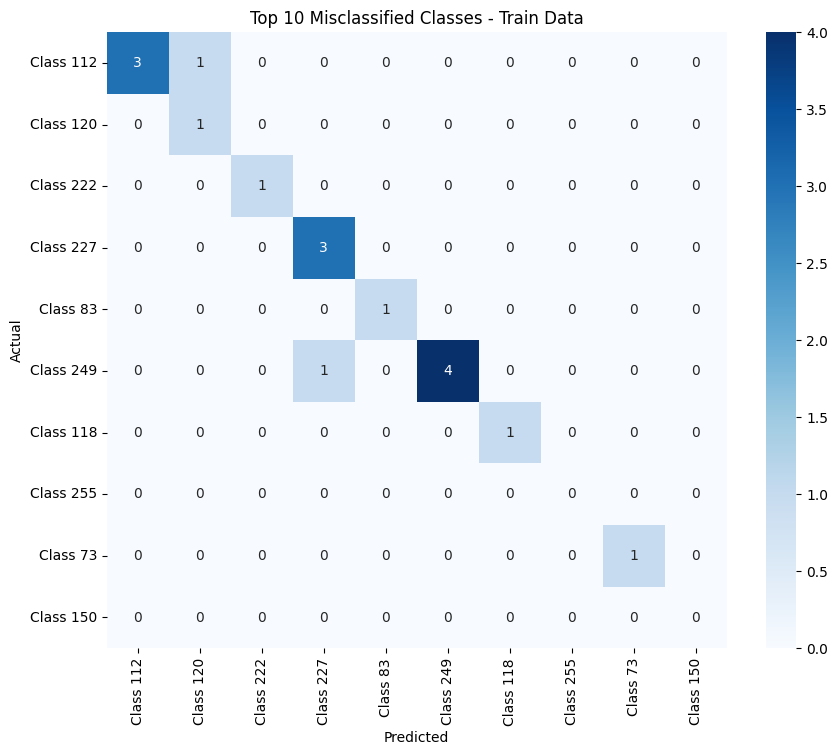

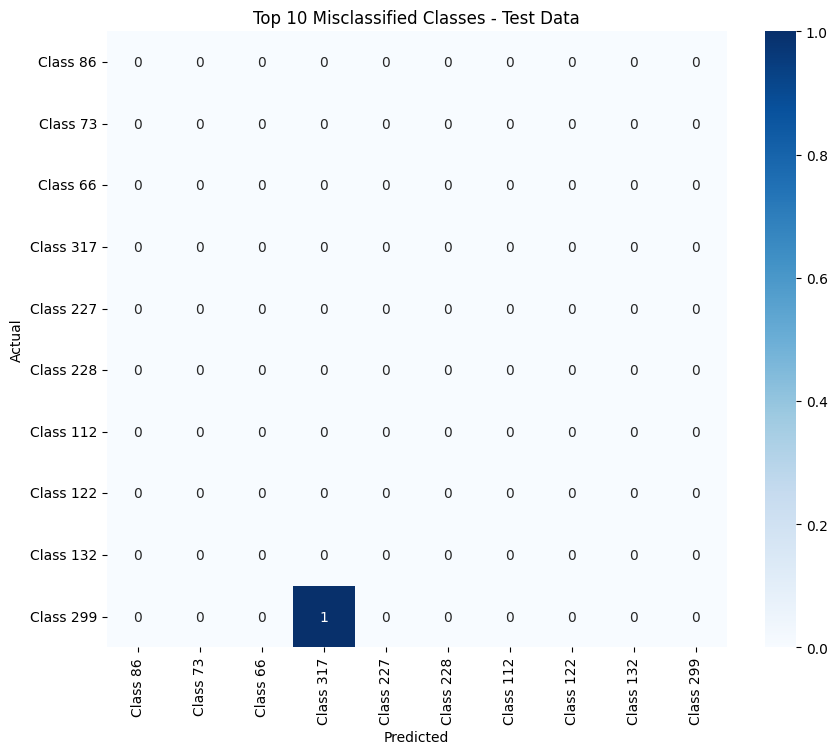

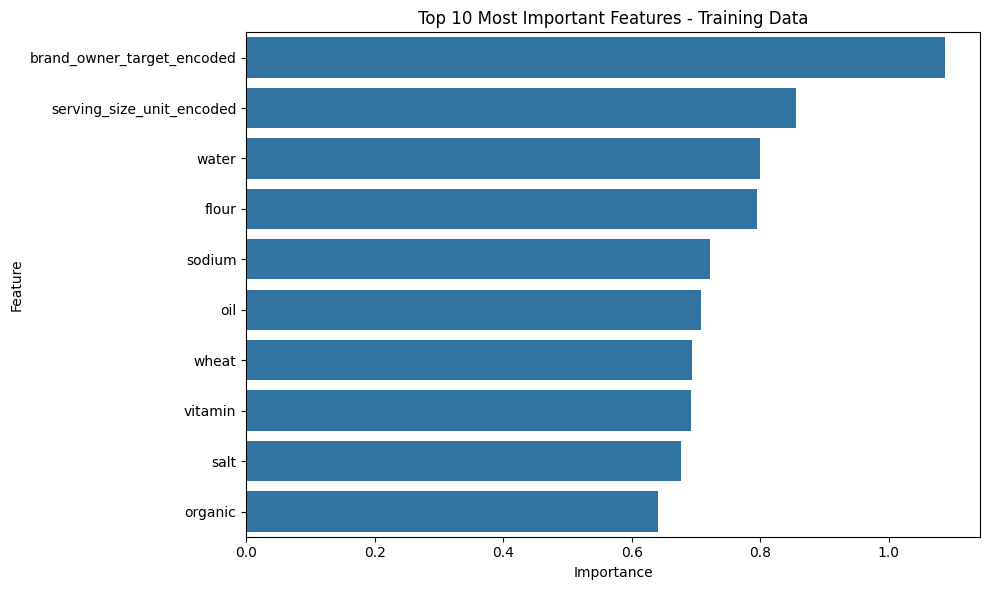

Top 10 Most Important Features:
                        Feature  Importance
107  brand_owner_target_encoded    1.087331
6     serving_size_unit_encoded    0.855490
99                        water    0.800142
41                        flour    0.794384
81                       sodium    0.721657
60                          oil    0.707204
100                       wheat    0.693901
98                      vitamin    0.692238
77                         salt    0.676491
63                      organic    0.640530
Using subset: 10k
Training Metrics:
train_accuracy: 0.631375
train_f1_macro: 0.6098262017933328
train_f1_weighted: 0.6080726558089409
train_log_loss: 2.1607956777539186
train_roc_auc: 0.985430921515604

Testing Metrics:
test_accuracy: 0.5335
test_f1_macro: 0.5004987693101534
test_f1_weighted: 0.497329060466048
test_log_loss: 2.5411828125107148
test_roc_auc: 0.9663730752936233


In [ ]:
run_model_LR_in_batches("10k")

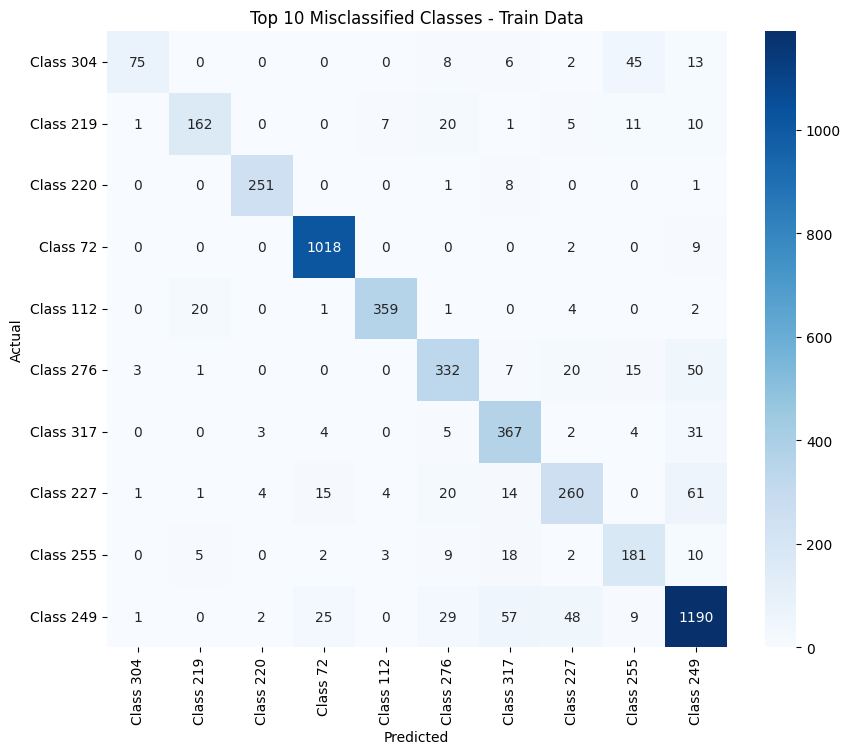

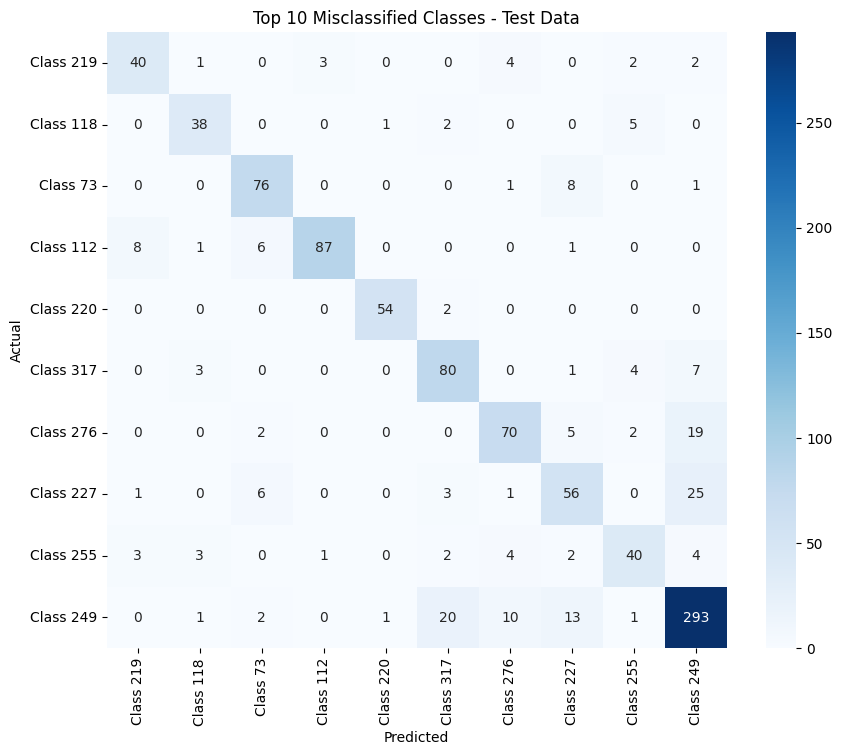

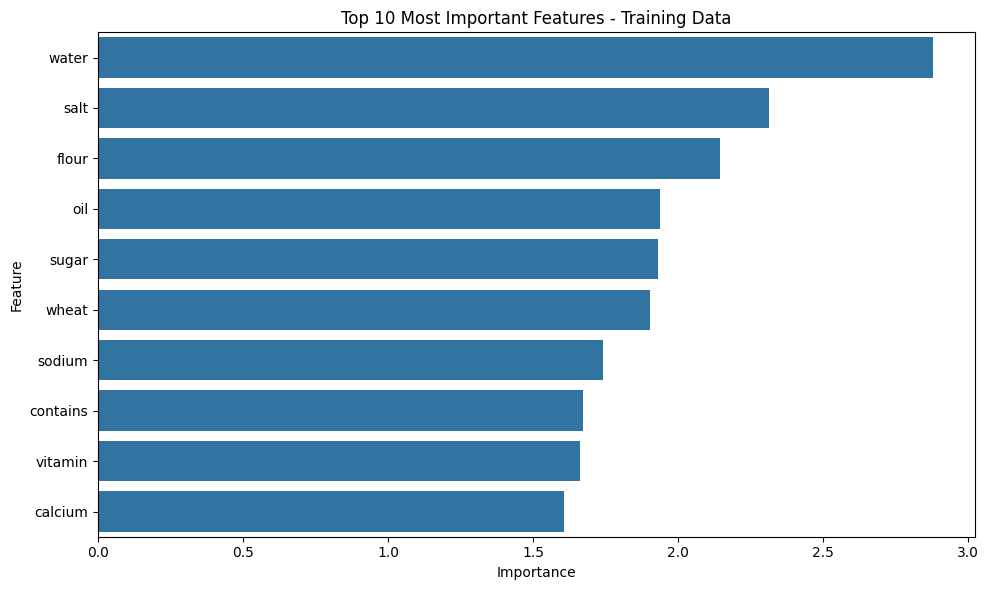

Top 10 Most Important Features:
      Feature  Importance
99      water    2.878980
77       salt    2.313326
41      flour    2.144137
60        oil    1.938499
86      sugar    1.929655
100     wheat    1.903361
81     sodium    1.741741
27   contains    1.670793
98    vitamin    1.662588
16    calcium    1.605914
Using subset: 250k
Training Metrics:
train_accuracy: 0.62687
train_f1_macro: 0.6637956622469018
train_f1_weighted: 0.6170199281951468
train_log_loss: 1.5681653331736365
train_roc_auc: 0.9892680284259233

Testing Metrics:
test_accuracy: 0.61782
test_f1_macro: 0.6571298774897953
test_f1_weighted: 0.6070322093171174
test_log_loss: 1.6195929426597402
test_roc_auc: 0.9881828145116303


In [ ]:
run_model_LR_in_batches("250k")

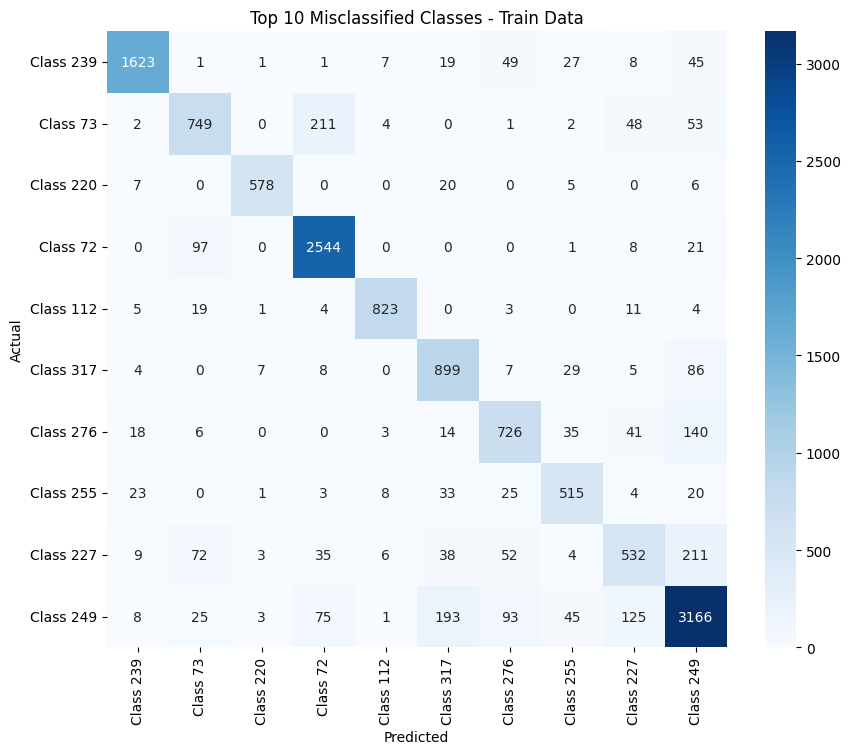

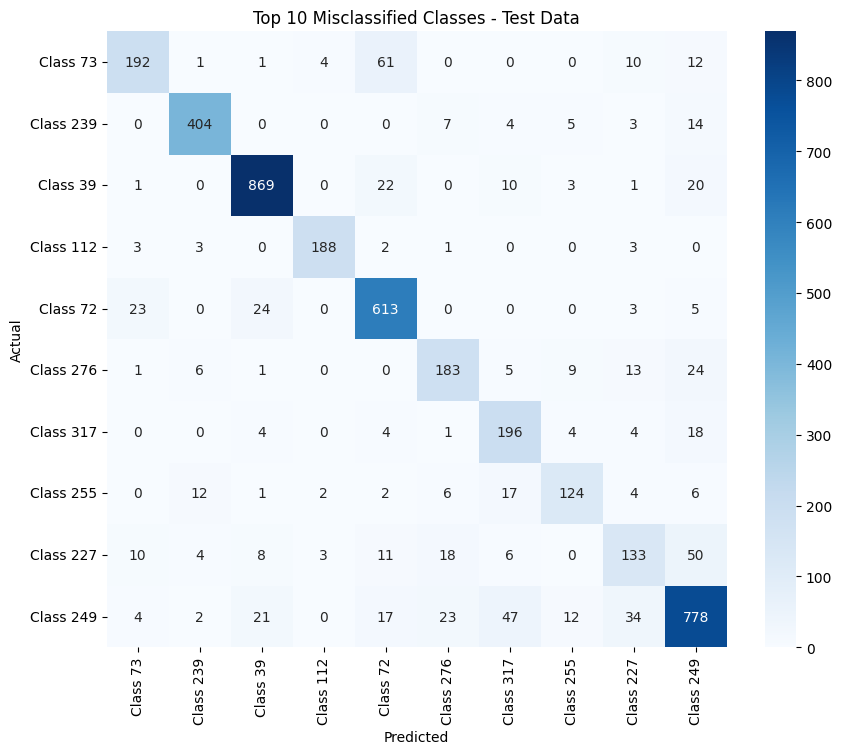

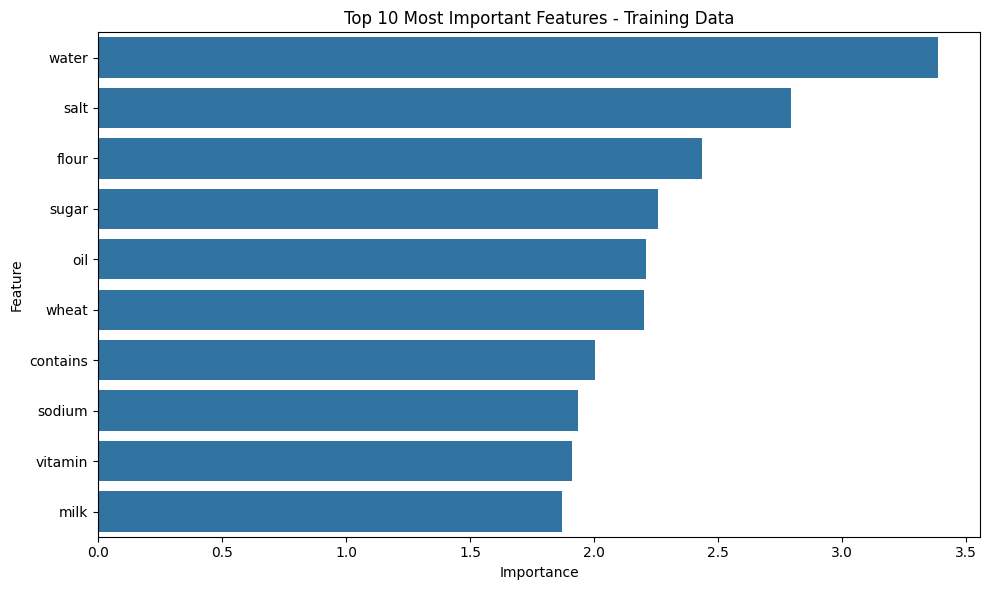

Top 10 Most Important Features:
      Feature  Importance
99      water    3.386229
77       salt    2.792754
41      flour    2.434090
86      sugar    2.256033
60        oil    2.209867
100     wheat    2.199272
27   contains    2.002677
81     sodium    1.935720
98    vitamin    1.911283
52       milk    1.870557
Using subset: 500k
Training Metrics:
train_accuracy: 0.62199
train_f1_macro: 0.6459770530719018
train_f1_weighted: 0.6116507447329164
train_log_loss: 1.5555658009949205
train_roc_auc: 0.9895660121196675

Testing Metrics:
test_accuracy: 0.61612
test_f1_macro: 0.6370711822174421
test_f1_weighted: 0.6055842281681185
test_log_loss: 1.5800007148319535
test_roc_auc: 0.9889398952006968


In [ ]:
run_model_LR_in_batches("500k")

### Observations Based on Subset Results and Metrics:

#### General Observations Across Subsets:
1. **Top Features:**
   - Across all subsets, key features like **water**, **salt**, **flour**, and **wheat** consistently appear as highly important. These features likely capture essential differences in food categories and are critical predictors for the model.
   - As the dataset size increases, the relative importance values of these features stabilize, indicating more robust feature evaluation.

2. **Model Performance Trends:**
   - **Accuracy and F1 Scores:** Both training and testing metrics improve as the subset size increases, indicating that larger datasets allow the model to generalize better.
   - **Log Loss:** Gradual improvement in log loss across larger subsets suggests the model's confidence in its predictions improves with more data.
   - **ROC-AUC:** High values for ROC-AUC (above 0.98) across all subsets demonstrate that the model is good at distinguishing between classes, even with smaller subsets.

3. **Misclassification Analysis:**
   - The first heatmap (10k subset) shows sparse misclassification data, highlighting the limited ability of the small dataset to capture class distributions effectively.
   - For the 250k and 500k subsets, the heatmaps show more populated matrices with clear patterns of misclassification, reflecting the increased complexity and class representation in larger datasets.

#### Specific Observations for Each Subset:

1. **10k Subset:**
   - **Performance:** 
     - Testing accuracy is relatively low (53.35%), and F1 scores are close to 50%, indicating the model struggles to generalize due to insufficient data.
     - A noticeable gap between training (63.13%) and testing (53.35%) accuracy suggests overfitting.
   - **Misclassification:** Sparse misclassification in the heatmap highlights that the model fails to capture sufficient class-level details.
   - **Justification:** The small sample size does not adequately represent the diverse food categories, leading to poor generalization.

2. **250k Subset:**
   - **Performance:**
     - Testing accuracy significantly improves to 61.78%, with F1 macro and weighted scores nearing 65%.
     - Log loss improves to 1.61 from 2.54, indicating better-calibrated predictions.
   - **Misclassification:** The second heatmap shows fewer missing classes but still exhibits considerable confusion between certain categories.
   - **Justification:** Increased data allows the model to learn better class distributions and feature interactions, reducing overfitting.

3. **500k Subset:**
   - **Performance:**
     - Metrics stabilize further with testing accuracy at 61.61% and F1 macro at 63.7%, indicating the model begins to converge with more data.
     - Log loss further improves to 1.58, showing confidence in predictions.
   - **Misclassification:** The third heatmap indicates broader coverage of classes with fewer missing labels, but errors persist in distinguishing some closely related categories.
   - **Justification:** This subset offers a more balanced representation of the dataset, leading to improved generalization and robustness.

#### Conclusion:
- **Trade-offs:** While small subsets like 10k are computationally efficient, their limited diversity results in poor generalization. Larger subsets (250k and 500k) offer significantly better performance, capturing more comprehensive class relationships.
- **Recommendation:** For predictive tasks with a large number of categories like the USDA dataset, subsets of 250k or larger are preferable to ensure sufficient class representation and model stability.

### Why Try XGBoost Next?

After evaluating the performance of **Logistic Regression** on the USDA dataset, there are compelling reasons to consider **XGBoost** as the next model to try:

1. **Ability to Capture Nonlinear Relationships**:
   - Logistic Regression assumes a **linear relationship** between features and the target variable, which may not hold true for the USDA dataset's complexity. XGBoost, being a tree-based boosting method, can effectively model **nonlinear interactions** between features.

2. **Handling High Dimensionality**:
   - The dataset contains a mix of numerical and categorical features, as well as TF-IDF-transformed ingredient features. XGBoost is particularly adept at handling **high-dimensional data**, unlike Logistic Regression, which may struggle with correlated or sparse features.

3. **Better Performance on Imbalanced Data**:
   - Logistic Regression performance on imbalanced data relies heavily on feature scaling and adjustments to class weights. XGBoost offers built-in **balanced objective functions** and custom evaluation metrics, making it better equipped for handling the imbalanced food category labels.

4. **Feature Importance Analysis**:
   - While Logistic Regression coefficients offer some interpretability, XGBoost provides a more **granular understanding** of feature importance through **gain, weight, and coverage metrics**, helping to uncover key drivers for food category prediction.

5. **Handling Multiclass Classification**:
   - XGBoost supports multiclass classification directly using its **softmax objective function**, ensuring better probabilistic outputs and improving metrics like log_loss and ROC-AUC observed in Logistic Regression.

6. **Efficiency for Large Datasets**:
   - Logistic Regression’s performance can degrade with large datasets and high-dimensional features due to its reliance on iterative optimization. XGBoost’s **parallelism** and **histogram-based learning** make it efficient and scalable for large datasets, like the 31-million-row USDA dataset.

7. **Overcoming Overfitting**:
   - Logistic Regression can be prone to **underfitting** due to its simplicity. So, by allowing non-linear relationships through decision trees in XGBoost and by using an ensemble of trees, which captures complex patterns in the data that logistic regression, a linear model, cannot.

In [ ]:
from xgboost import XGBClassifier

def run_xgboost_in_batches(subset_key, batch_size=50000, random_seed=42):
    """Run XGBoost model on the specified subset in batches."""
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    random.seed(random_seed)

    # Ensure subset exists
    if subset_key not in subsets or subsets[subset_key] is None:
        print(f"Subset {subset_key} not available.")
        return

    df = subsets[subset_key].copy()

    # Target column name
    target_col = df.columns[-1]  # Assuming the target is the last column

    # Prepare features and target
    X = df.iloc[:, :-1]  # Features
    y = df[target_col]   # Target

    # Split the data into training and testing sets
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_seed, stratify=y
        )
    except ValueError as e:
        print(f"Error during train-test split for subset {subset_key}: {e}")
        return

    # Train an XGBoost Classifier
    model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        eval_metric='mlogloss',
        random_state=random_seed,
        verbosity=1
    )
    model.fit(X_train, y_train)

    # Batch processing
    def process_batches(X, batch_size):
        num_batches = (len(X) + batch_size - 1) // batch_size
        preds, probs = [], []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(X))
            X_batch = X[start_idx:end_idx]
            preds.append(model.predict(X_batch))
            probs.append(model.predict_proba(X_batch))
        return np.concatenate(preds), np.concatenate(probs)

    # Process training and testing sets in batches
    y_train_pred, y_train_proba = process_batches(X_train, batch_size)
    y_test_pred, y_test_proba = process_batches(X_test, batch_size)

    # Metrics
    metrics = {
        "train_accuracy": accuracy_score(y_train, y_train_pred),
        "test_accuracy": accuracy_score(y_test, y_test_pred),
        "train_f1_macro": f1_score(y_train, y_train_pred, average='macro'),
        "test_f1_macro": f1_score(y_test, y_test_pred, average='macro'),
        "train_f1_weighted": f1_score(y_train, y_train_pred, average='weighted'),
        "test_f1_weighted": f1_score(y_test, y_test_pred, average='weighted'),
        "train_log_loss": log_loss(y_train, y_train_proba),
        "test_log_loss": log_loss(y_test, y_test_proba),
        "train_roc_auc": roc_auc_score(y_train, y_train_proba, multi_class='ovr'),
        "test_roc_auc": roc_auc_score(y_test, y_test_proba, multi_class='ovr'),
    }

    # Confusion Matrices
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Visualize Most Misclassified Classes
    def plot_confusion_matrix_top_classes(conf_matrix, class_names, top_n=10, dataset_type="Train"):
        # Calculate misclassifications
        misclassified_counts = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
        top_classes = np.argsort(misclassified_counts)[-top_n:]

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            conf_matrix[np.ix_(top_classes, top_classes)],
            annot=True, fmt='d', cmap='Blues',
            xticklabels=[class_names[i] for i in top_classes],
            yticklabels=[class_names[i] for i in top_classes]
        )
        plt.title(f"Top {top_n} Misclassified Classes - {dataset_type} Data")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    # Class names for confusion matrix visualization
    class_names = [f"Class {i}" for i in range(len(set(y)))]

    # Plot Confusion Matrices for top misclassified classes
    plot_confusion_matrix_top_classes(train_conf_matrix, class_names, top_n=10, dataset_type="Train")
    plot_confusion_matrix_top_classes(test_conf_matrix, class_names, top_n=10, dataset_type="Test")

    # Calculate feature importances
    feature_importances = model.feature_importances_
    feature_names = X.columns  # Feature names

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Plot the top 10 most important features
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importance_df.head(10))
    plt.title("Top 10 Most Important Features")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # Print the top 10 features
    print("Top 10 Most Important Features:")
    print(importance_df.head(10))

    # Print Results
    print(f"Using subset: {subset_key}")
    print("Training Metrics:")
    for metric, value in metrics.items():
        if "train" in metric:
            print(f"{metric}: {value}")
    print("\nTesting Metrics:")
    for metric, value in metrics.items():
        if "test" in metric:
            print(f"{metric}: {value}")


### Explanation of the XGBoost Code

1. **Data Splitting:**
   - The data is split into training and testing sets using train_test_split with stratification to preserve the label distribution in both sets.

2. **Model Initialization:**
   - An XGBClassifier is initialized with:
     - **n_estimators=100:** Specifies the number of trees in the model. A larger number of trees can increase model accuracy but may also increase training time and risk of overfitting.
     - **max_depth=6:** Sets the maximum depth of the trees. Limiting depth prevents overfitting while maintaining sufficient complexity for learning patterns in the data.
     - **learning_rate=0.1:** Determines the step size during gradient descent. A lower value ensures slower but more precise updates, improving the model's stability.
     - **eval_metric=mlogloss:** Uses multiclass log loss as the evaluation metric, which is appropriate for evaluating probabilistic predictions in multiclass classification.
     - **random_state=42:** Ensures reproducibility of results by controlling the randomness in data splitting and model training.

3. **Batch Processing for Predictions:**
   - Predictions and probabilities are processed in batches to handle memory constraints on large datasets.

4. **Metrics Calculation:**
   - Metrics such as accuracy, F1 scores (macro and weighted), log loss, and ROC-AUC are computed for both training and testing sets to assess the model's performance comprehensively.

5. **Confusion Matrix Visualization:**
   - The top 10 misclassified classes are visualized using confusion matrices for training and testing datasets to identify patterns of errors and poorly predicted classes.

6. **Feature Importance:**
   - The model's feature importances are extracted using model.feature_importances_ and visualized to identify the most influential features in predicting the target variable.

7. **Final Results:**
   - Metrics and the top 10 most important features are printed and visualized for analysis, helping understand the model's behavior and key predictors.


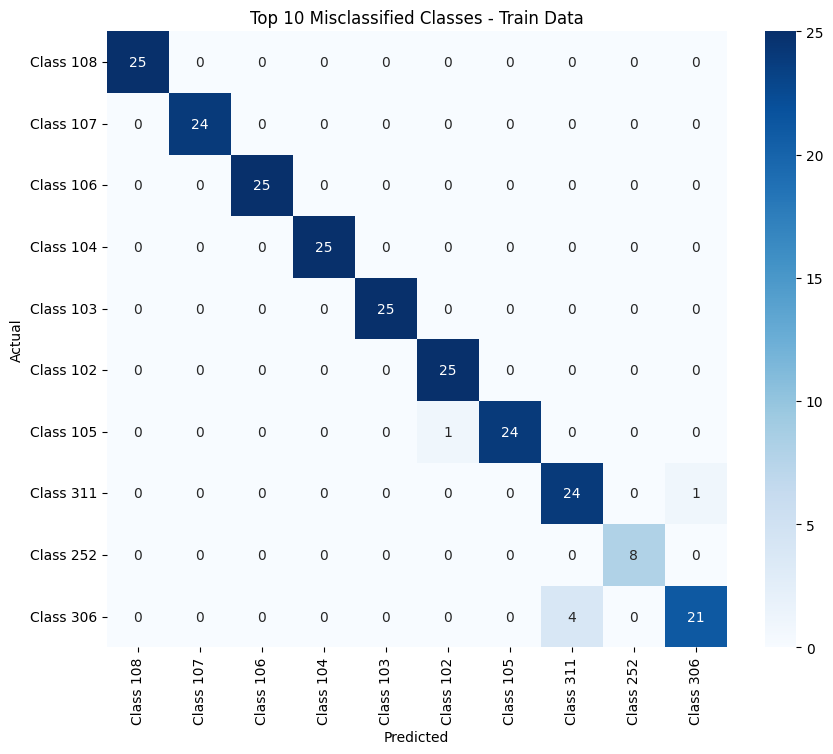

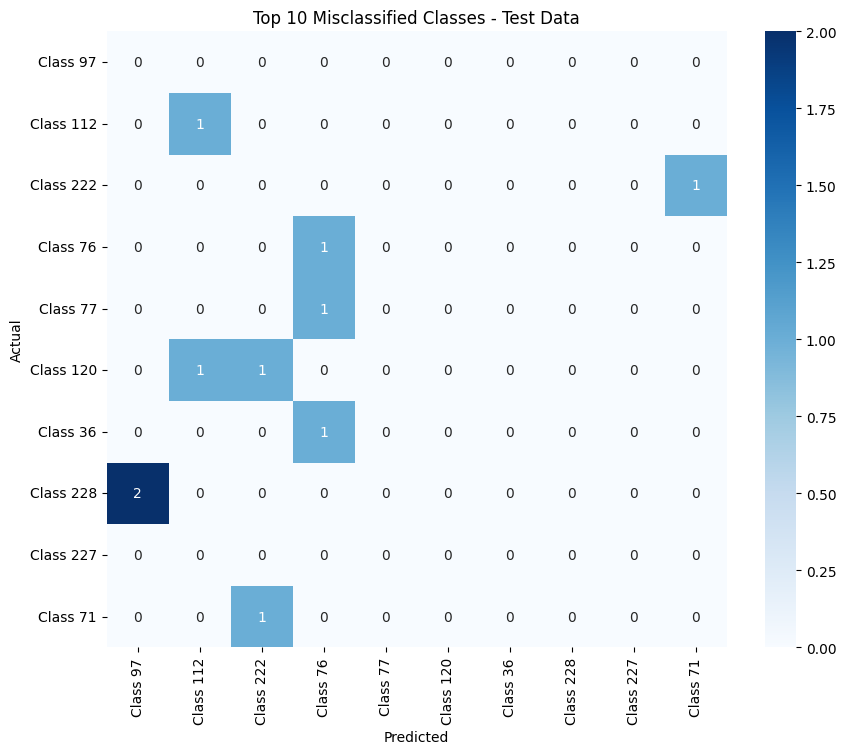

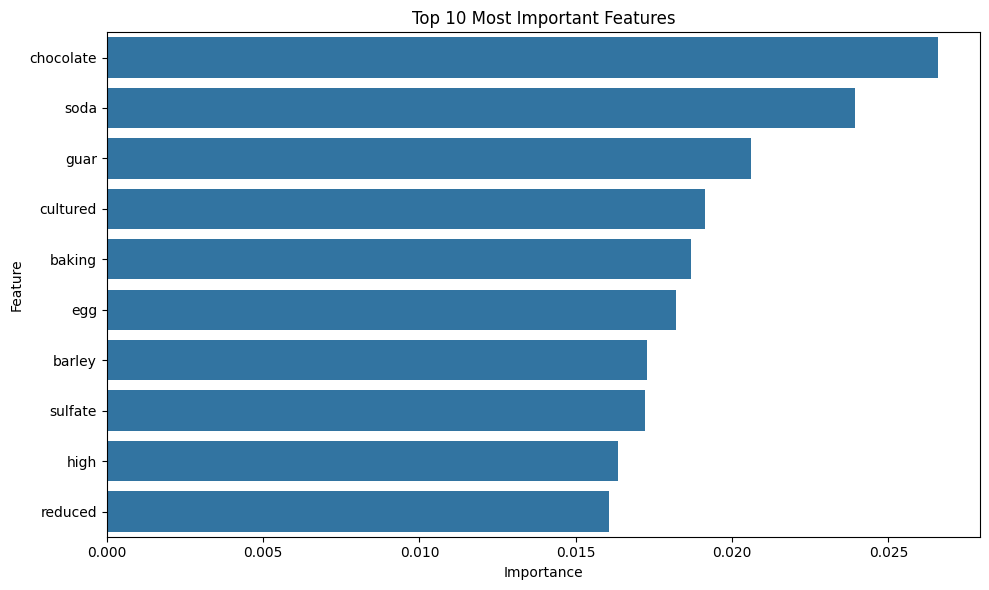

Top 10 Most Important Features:
      Feature  Importance
21  chocolate    0.026603
80       soda    0.023937
44       guar    0.020598
30   cultured    0.019129
11     baking    0.018696
35        egg    0.018195
12     barley    0.017295
87    sulfate    0.017221
46       high    0.016358
74    reduced    0.016070
Using subset: 10k
Training Metrics:
train_accuracy: 0.999
train_f1_macro: 0.9986249726404112
train_f1_weighted: 0.9989951665982014
train_log_loss: 0.07070109914560496
train_roc_auc: 0.999999408380591

Testing Metrics:
test_accuracy: 0.7015
test_f1_macro: 0.6948581226348854
test_f1_weighted: 0.6929107484019249
test_log_loss: 1.355190547183321
test_roc_auc: 0.9872903217045566


In [ ]:
run_xgboost_in_batches("10k")


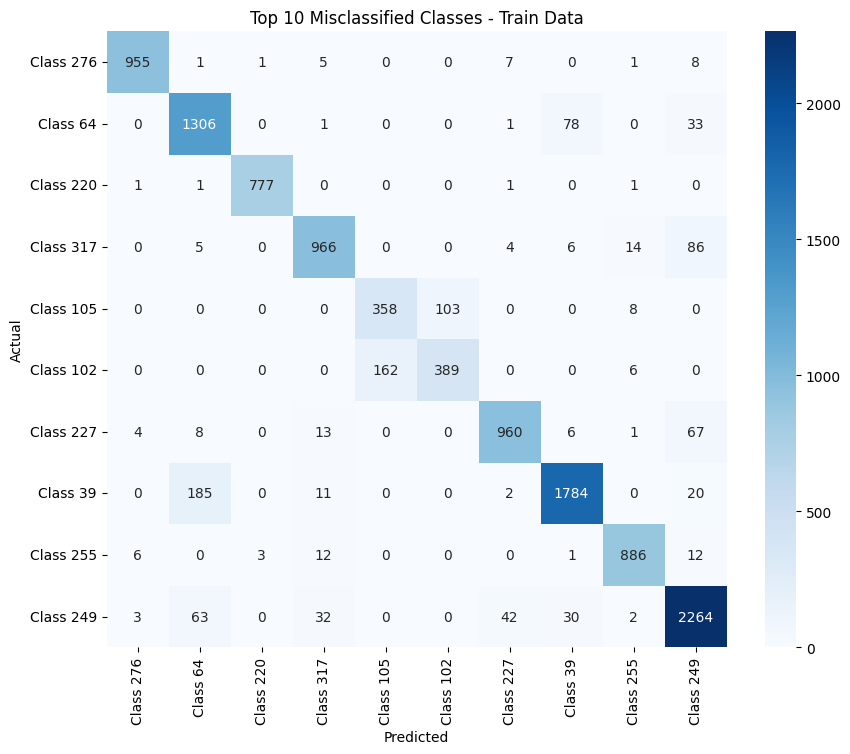

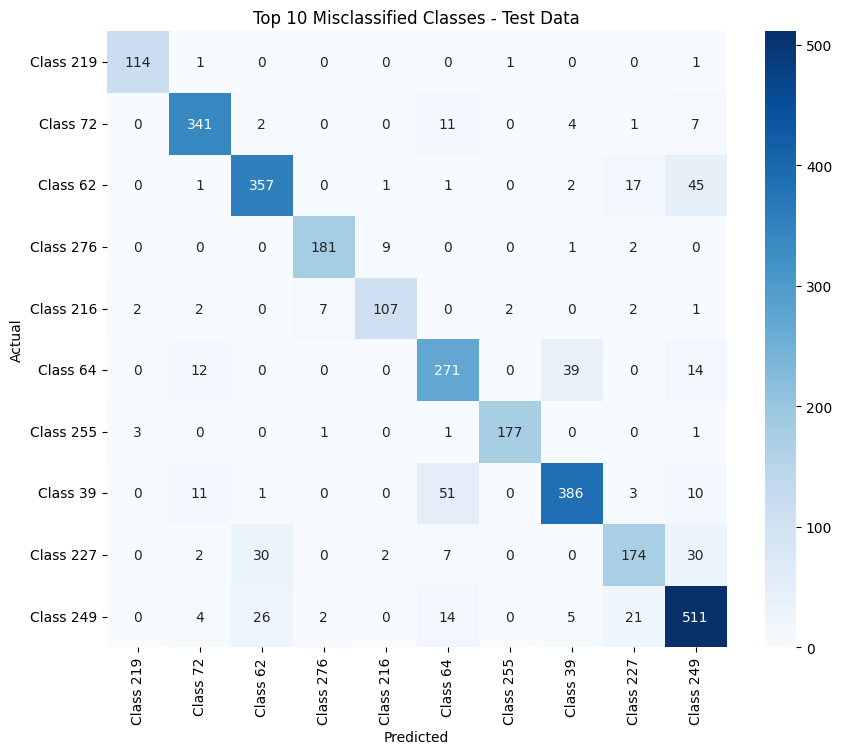

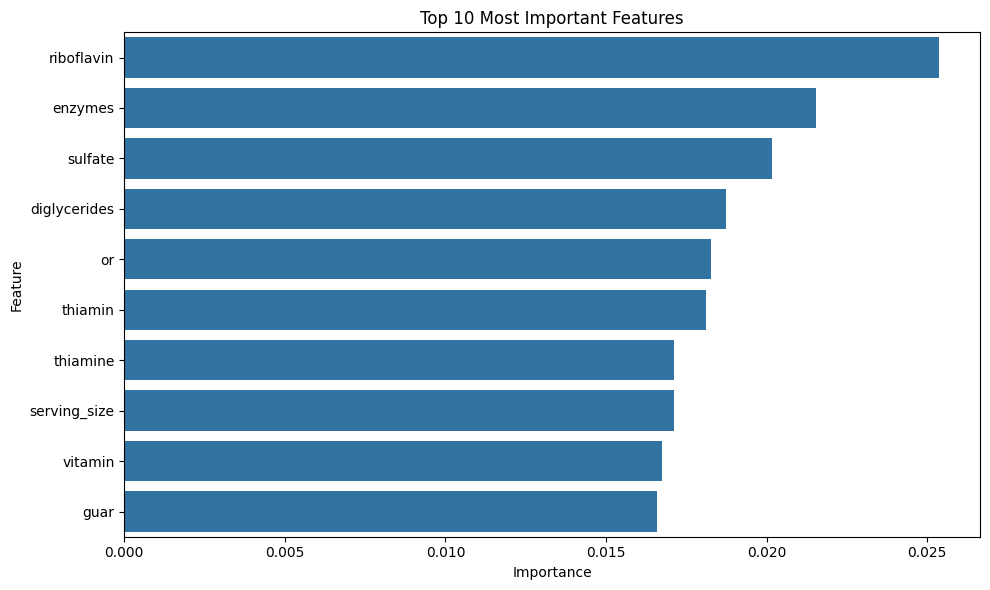

Top 10 Most Important Features:
         Feature  Importance
75    riboflavin    0.025377
37       enzymes    0.021531
87       sulfate    0.020179
33  diglycerides    0.018752
62            or    0.018261
91       thiamin    0.018103
92      thiamine    0.017124
0   serving_size    0.017118
98       vitamin    0.016750
44          guar    0.016574
Using subset: 250k
Training Metrics:
train_accuracy: 0.92457
train_f1_macro: 0.9426288684848025
train_f1_weighted: 0.9242630251234691
train_log_loss: 0.3010786690681205
train_roc_auc: 0.9997173451906934

Testing Metrics:
test_accuracy: 0.84698
test_f1_macro: 0.8818572557237458
test_f1_weighted: 0.8459257459208495
test_log_loss: 0.5951709033342291
test_roc_auc: 0.9977653646420258


In [ ]:
run_xgboost_in_batches("250k")


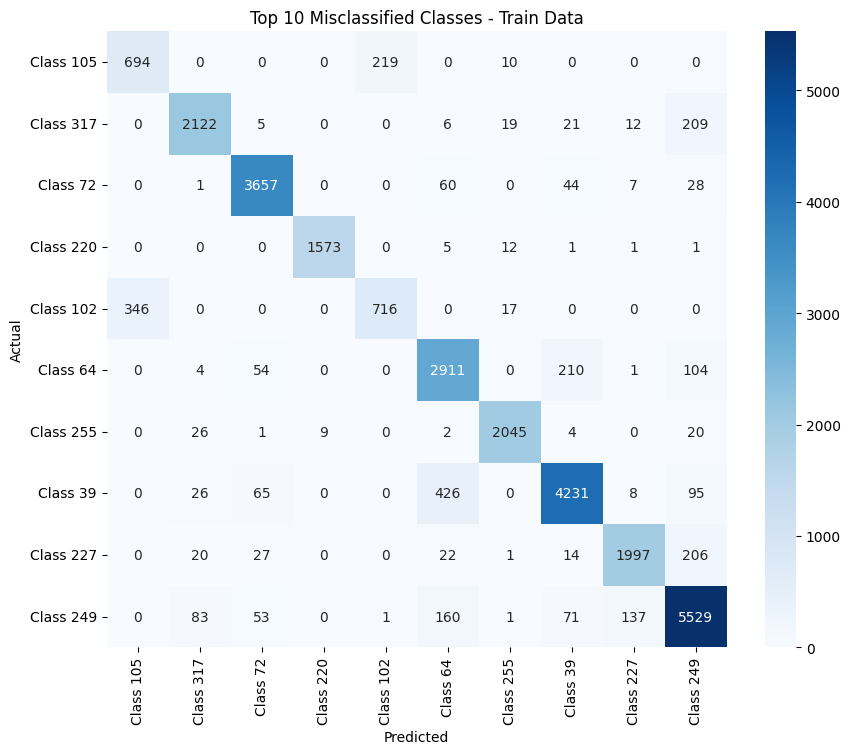

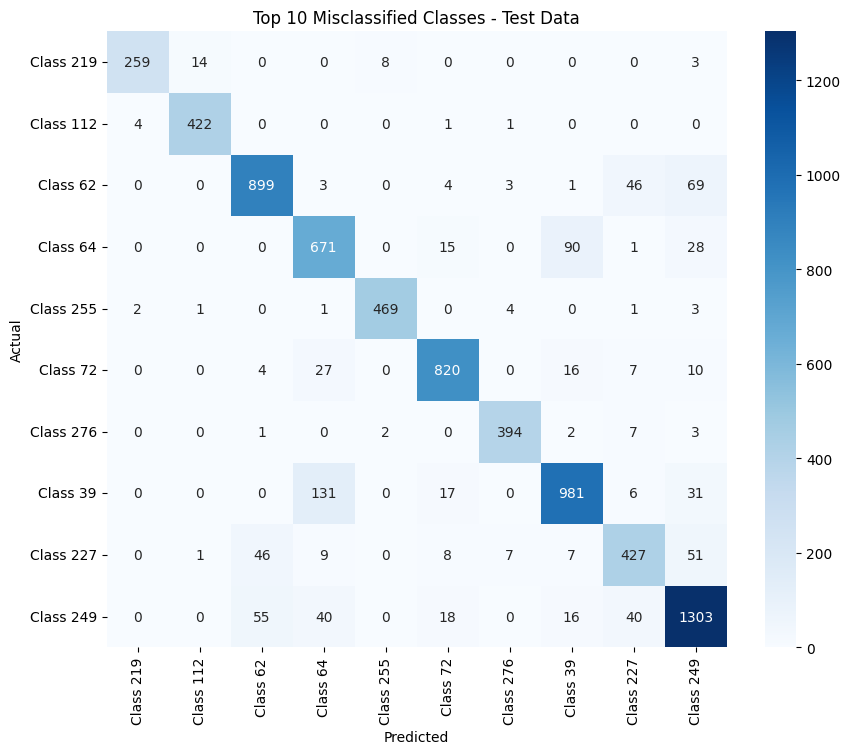

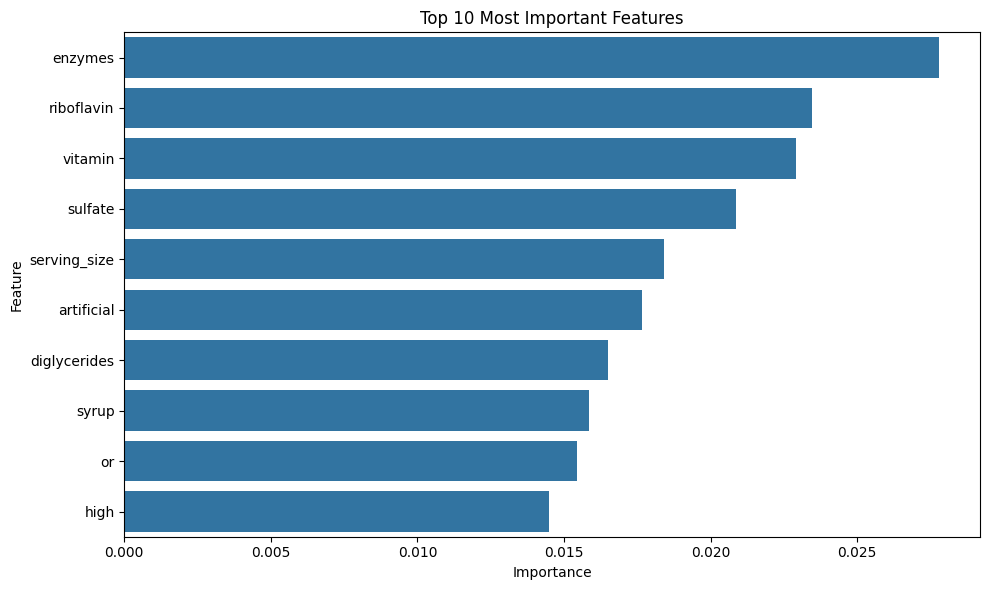

Top 10 Most Important Features:
         Feature  Importance
37       enzymes    0.027801
75    riboflavin    0.023450
98       vitamin    0.022911
87       sulfate    0.020880
0   serving_size    0.018396
9     artificial    0.017646
33  diglycerides    0.016511
89         syrup    0.015869
62            or    0.015460
46          high    0.014473
Using subset: 500k
Training Metrics:
train_accuracy: 0.904405
train_f1_macro: 0.9298850348792502
train_f1_weighted: 0.9040124836507676
train_log_loss: 0.3596705299381468
train_roc_auc: 0.9995010142713232

Testing Metrics:
test_accuracy: 0.85868
test_f1_macro: 0.8890855831445941
test_f1_weighted: 0.8577760824716842
test_log_loss: 0.5399820476495824
test_roc_auc: 0.9982799203720826


In [ ]:
run_xgboost_in_batches("500k")


### Analysis of XGBoost Results Across Subsets

#### Subset 10k Analysis:
- **Training Performance:**
  - Extremely high accuracy and F1 scores close to 1 indicate potential overfitting.
  - Very low training log loss and ROC-AUC near perfect suggest the model performs exceptionally well on the training data.
- **Testing Performance:**
  - A noticeable drop in accuracy (70.15%) and F1 scores compared to training metrics reflects overfitting to the small training data.
  - Log loss of 1.35 indicates the model's confidence in predictions isn't optimal for some classes.
  - ROC-AUC of 98.72% suggests the model still performs reasonably well overall, but the misclassifications (seen in confusion matrix) highlight weaknesses in classifying some labels.
- **Feature Importance:**
  - Ingredients like chocolate, soda, and baking dominate importance, which is expected as the subset might have limited variation.

#### Subset 250k Analysis:
- **Training Performance:**
  - Accuracy (92.46%) and F1 scores (macro: 94.26%, weighted: 92.42%) remain very high with significantly reduced overfitting compared to the 10k subset.
  - Log loss decreases to 0.30, showing a significant improvement in prediction confidence.
  - ROC-AUC near 1 suggests the model effectively learns from the expanded data.
- **Testing Performance:**
  - Testing accuracy increases to 84.69%, with F1 scores improving correspondingly (macro: 88.19%, weighted: 84.59%).
  - Testing log loss reduces significantly to 0.59, reflecting better-calibrated probabilities.
  - ROC-AUC of 99.78% indicates robust performance on unseen data, showcasing generalization improvements due to the larger dataset.
- **Feature Importance:**
  - Features like riboflavin, enzymes, and vitamin gain prominence, highlighting the model's ability to capture nutritional details from the dataset.

#### Subset 500k Analysis:
- **Training Performance:**
  - Marginally lower training accuracy (90.44%) and F1 scores (macro: 92.99%, weighted: 90.40%) compared to the 250k subset suggest reduced overfitting.
  - Log loss slightly increases to 0.36, but it remains low, reflecting well-calibrated predictions.
  - ROC-AUC remains very high (99.95%), showing excellent training performance.
- **Testing Performance:**
  - Testing accuracy improves further to 85.87%, along with macro F1 (88.91%) and weighted F1 (85.78%).
  - Testing log loss reduces to 0.54, showcasing a better balance between prediction confidence and error minimization.
  - ROC-AUC at 99.82% confirms strong generalization capabilities across classes.
- **Feature Importance:**
  - Key features remain similar to the 250k subset, with enzymes, riboflavin, and vitamin showing consistent importance.
  - Some new features like syrup and artificial appear, indicating additional relationships captured by the larger dataset.

### Comparison with Logistic Regression

1. **Generalization:**
   - XGBoost demonstrates significantly better testing accuracy, F1 scores, and log loss values across all subsets compared to logistic regression. 
   - For example, on the 10k subset, logistic regression achieves a testing accuracy of 53.35%, whereas XGBoost improves it to 70.15%.

2. **Feature Utilization:**
   - XGBoost dynamically identifies and leverages non-linear relationships between features (e.g., riboflavin, enzymes) to improve predictions, which logistic regression struggles to capture due to its linear nature.

3. **Overfitting and Class Representation:**
   - Logistic regression suffers from underfitting on small subsets due to its simplicity, while XGBoost combats this by using more sophisticated decision trees, better handling complex patterns even in limited data.

### General Observations:
1. **Overfitting Control:** 
   - The transition from the 10k to 500k subset demonstrates a clear reduction in overfitting, with metrics stabilizing and testing performance aligning more closely with training.
2. **Impact of Larger Datasets:**
   - Larger subsets enable the model to generalize better, as evidenced by higher testing accuracy and lower log loss.
   - Increased subset sizes help XGBoost capture intricate patterns in the data while improving its ability to handle class imbalances.
3. **Feature Importance Evolution:**
   - As the dataset grows, the model shifts focus to more nuanced and diverse features, suggesting an improved understanding of the dataset's complexity.
4. **Class Misclassification:**
   - Misclassifications are prominent in the smaller subset (10k), with confusion matrices indicating poor handling of less-represented classes. Larger subsets address these issues better, as shown by the reduction in off-diagonal errors in confusion matrices for 250k and 500k subsets.